# 2020-07-28 • Storing values in base units

..but specifying and displaying them in physiological / most natural units

`unyt.convert_to_base()` is slow. So we don't want to call this in our processing functions.

Solution: store all units in base units throughout calculation, and only do conversion at
user interaction time. That is, when:
 - defining parameters
 - printing values
 - plotting

This notebook prototypes this solution.

(Alternative solutions we don't explore here:
 - use Brian, which has it's own unit system builtin.
 - program in Julia

).

In [2]:
%run init.ipynb

Importing np, mpl, plt … ✔
Importing unyt … ✔
Importing code package (voltage_to_wiring_sim), as `v` … ✔
Imported * from v.units

To see the source code responsible for this notebook:

- Go to
  https://github.com/tfiers/voltage-to-wiring-sim/tree/master/notebooks

- In the file listing, click the commit message 
  next to this notebook's name

- Click the "Browse files" button.

This shows the entire repository as it was 
when this notebook was last modified.


In [194]:
class Array(unyt_array):
    def __new__(cls, *args, **kwargs):
        obj = super().__new__(cls, *args, **kwargs)
        obj.display_units = obj.units
        if not obj.units.is_dimensionless:
            obj = obj.astype('float64')
            obj.convert_to_base('mks')
        return obj
    
    def __array_finalize__(self, obj):
        super().__array_finalize__(obj)
        self.display_units = getattr(obj, "display_units", None)
    
    @property
    def in_display_units(self):
        if self.units.is_dimensionless:
            return unyt_array(self)
        else:
            # Note that we can't return `self.to(self.display_units)` here, as that
            # would convert to base units again (in __new__).
            return unyt_array(self).to(self.display_units)

    def __repr__(self):
        clsname = self.__class__.__name__
        if self.units.is_dimensionless:
            return f"{clsname}({str(self)}, {self.dtype})"
        else:
            return f"{clsname}({str(self)}, stored in {self.units}, {self.dtype})"
    
    def __str__(self):
        if self.units.is_dimensionless:
            return f"{self.value} (dimensionless)"
        else:
            return str(self.in_display_units)

    
class Quantity(Array, unyt_quantity):
    ...

a = Array([1.0,2,3], mV, name="Potential")

q = Quantity(1, mV/mV)
q

Quantity(1 (dimensionless), int32)

In [187]:
print(q)

1 (dimensionless)


In [190]:
a

Array([1 2 3] mV, stored in V, float64)

In [185]:
print(a)

[1 2 3] mV


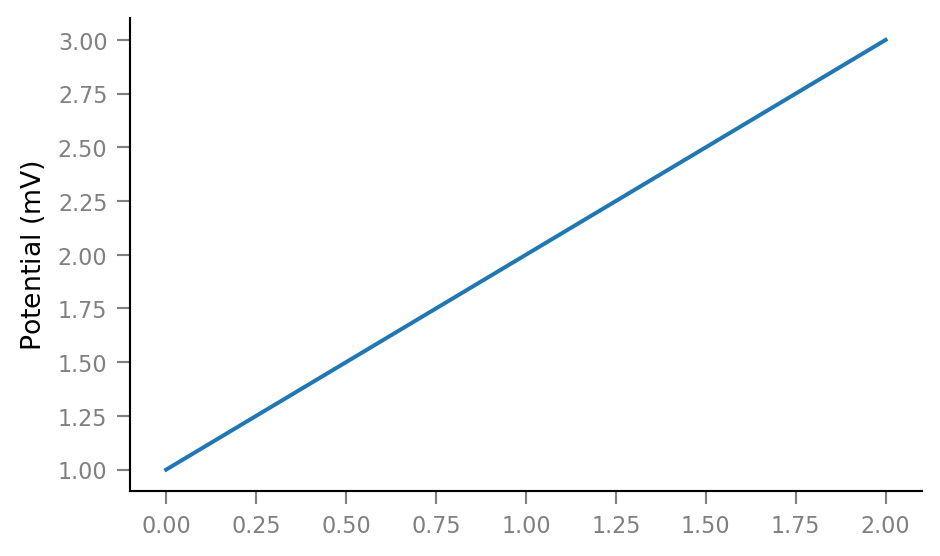

In [227]:
from unyt.mpl_interface import unyt_arrayConverter
from matplotlib.units import registry, ConversionInterface

class MyConversionInterface(unyt_arrayConverter):
    def __new__(cls):
        return super(ConversionInterface, cls).__new__(cls)
    
    @staticmethod
    def default_units(x: Array, axis):
        unyt_arrayConverter().default_units(x, axis)
        return x.display_units
    
    @staticmethod
    def convert(value: Array, unit, axis):
        return unyt_arrayConverter().convert(
            value.in_display_units, unit, axis=axis)
        
registry[Array] = MyConversionInterface()

plt.plot(a);

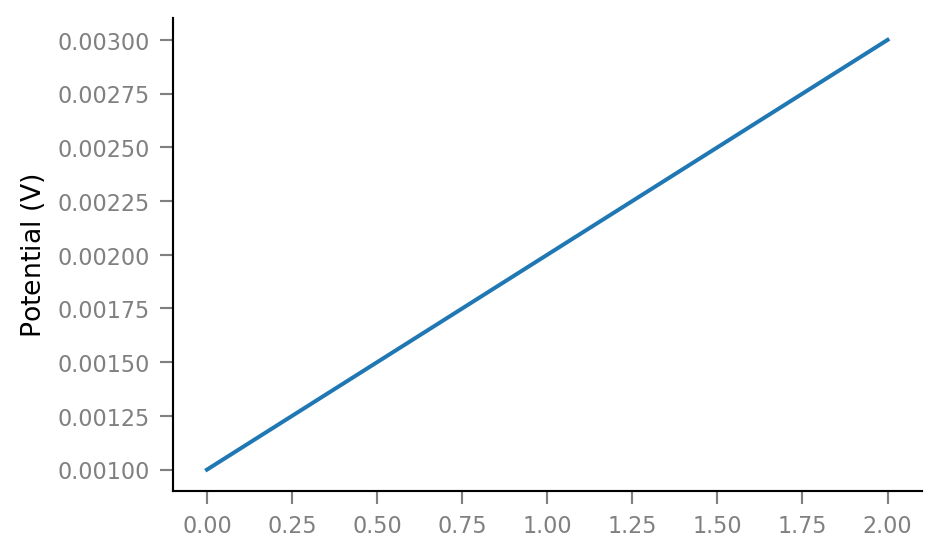

In [229]:
plt.plot(a, yunits=V);

It all works nicely :)

I will now integrate this code in the codebase.